In [90]:
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
#from pandas import read_csv
#from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.metrics import mean_absolute_error as mae
from sklearn.utils import shuffle

In [91]:
big_csv = pd.read_csv('out.csv', nrows = 2000000)

In [92]:
del big_csv['Unnamed: 0']

In [93]:
big_csv['State'] = big_csv['State'].str.replace('"', '')
big_csv['date'] = big_csv.groupby('Performance Record').cumcount() + 1

In [94]:
del big_csv['AvgSur']
del big_csv['AP']
del big_csv['MDNI']
# del big_csv['Cluster']
del big_csv['ADNI']
# del big_csv['State']

In [95]:
import random

groups = [big_csv for _, big_csv in big_csv.groupby('Performance Record')]
random.shuffle(groups)

big_csv = pd.concat(groups).reset_index(drop=True)

#big_csv = shuffle(big_csv)

In [96]:
big_csv = big_csv.set_index('Performance Record')

In [101]:
test = pd.read_csv('Output/prepared_test_data.csv')

In [103]:
del test['Unnamed: 0']

In [105]:
test['State'] = test['State'].str.replace('"', '')
test['date'] = test.groupby('Performance Record').cumcount() + 1

In [107]:
# prepare data for lstm
from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
#from pandas import read_csv
#from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
import datetime
import pandas as pd


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [111]:
#dataset = read_csv('LSTM_Model/avg_performance_record.csv', header=0, index_col=0)
dataset = big_csv
input_df = dataset[dataset.columns[:-1]]
output_df = pd.DataFrame(dataset['Yield'])
#test_df = pd.DataFrame(test)

# Define values that are input and output
values_input = input_df.values
values_output = output_df.values
#test_input = test.values

# Encoding the State Column
encoder = LabelEncoder()
values_input[:,5] = encoder.fit_transform(values_input[:,5])
#test_input[:,10] = encoder.fit_transform(test_input[:,10])

# Convert values to floats
values_input = values_input.astype('float32')
values_output = values_output.astype('float32')
#test_input = test_input.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_input = scaler.fit_transform(values_input)
scaled_output = scaler.fit_transform(values_output)
#scaled_test = scaler.fit_transform(test_input)

# frame as supervised learning
reframed_input = series_to_supervised(scaled_input, 1, 1)
reframed_output = series_to_supervised(scaled_output, 1, 1)
#reframed_test = series_to_supervised(scaled_test, 1, 1)

# drop columns we don't want to predict (keeping Yield in this case)
reframed_input.drop(reframed_input.columns[[8, 9, 10, 11, 12, 13, 14, 15]], axis=1, inplace=True)
#reframed_test.drop(reframed_test.columns[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]], axis=1, inplace=True)
#reframed_input.drop(reframed_input.columns[[12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]], axis=1, inplace=True)
print(reframed_input.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0   0.725946   0.000000   0.728672   0.908382   0.619342   
2        0.0   0.044865   0.000000   0.628304   0.250487   0.550411   
3        0.0   0.648735   0.055556   0.750976   0.953216   0.412551   
4        0.0   0.167027   0.000000   0.732798   0.370370   0.483539   
5        0.0   0.457297   0.055556   0.823464   0.926901   0.468107   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  var11(t-1)  var12(t-1)  
1   0.684100   0.627933   0.000000    0.444444    0.148148    0.583328  
2   0.715481   0.613154   0.004695    0.444444    0.148148    0.583328  
3   0.498954   0.455099   0.009390    0.444444    0.148148    0.583328  
4   0.540795   0.477550   0.014085    0.444444    0.148148    0.583328  
5   0.519874   0.482401   0.018779    0.444444    0.148148    0.583328  


In [113]:
## Define Input and Output values
values_input = reframed_input.values
values_output = reframed_output.values
#test_input = reframed_test.values

# Set train and validation split
n_train_hours = int(len(dataset)*0.80)

# Apply train and validation split for input and output
train_input = values_input[:n_train_hours, :]
train_output = values_output[:n_train_hours, :]
validation_input = values_input[n_train_hours:int(len(values_input)), :]
validation_output = values_output[n_train_hours:int(len(values_input)), :]

# assign split into input and outputs that make a little more sense
train_X, train_y = train_input, train_output
validation_X, validation_y = validation_input, validation_output
#test_X = test_input

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape, test_X.shape)

(1600000, 1, 8) (1600000, 2) (399999, 1, 8) (399999, 2) (2212117, 1, 12)


Epoch 1/35
5334/5334 - 21s - loss: 0.1229 - val_loss: 0.1179
Epoch 2/35
5334/5334 - 20s - loss: 0.1204 - val_loss: 0.1174
Epoch 3/35
5334/5334 - 22s - loss: 0.1195 - val_loss: 0.1163
Epoch 4/35
5334/5334 - 20s - loss: 0.1173 - val_loss: 0.1136
Epoch 5/35
5334/5334 - 20s - loss: 0.1150 - val_loss: 0.1132
Epoch 6/35
5334/5334 - 20s - loss: 0.1141 - val_loss: 0.1131
Epoch 7/35
5334/5334 - 21s - loss: 0.1137 - val_loss: 0.1125
Epoch 8/35
5334/5334 - 18s - loss: 0.1134 - val_loss: 0.1122
Epoch 9/35
5334/5334 - 19s - loss: 0.1132 - val_loss: 0.1118
Epoch 10/35
5334/5334 - 19s - loss: 0.1131 - val_loss: 0.1115
Epoch 11/35
5334/5334 - 19s - loss: 0.1129 - val_loss: 0.1113
Epoch 12/35
5334/5334 - 19s - loss: 0.1128 - val_loss: 0.1110
Epoch 13/35
5334/5334 - 21s - loss: 0.1126 - val_loss: 0.1109
Epoch 14/35
5334/5334 - 25s - loss: 0.1125 - val_loss: 0.1108
Epoch 15/35
5334/5334 - 26s - loss: 0.1124 - val_loss: 0.1107
Epoch 16/35
5334/5334 - 26s - loss: 0.1122 - val_loss: 0.1106
Epoch 17/35
5334/

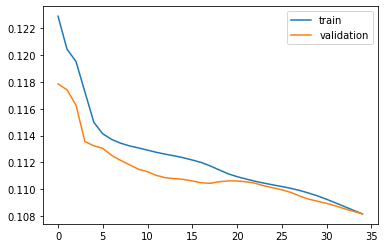

In [114]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=35, batch_size=300, validation_data=(validation_X, validation_y), verbose=2, shuffle=False)
#plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')
pyplot.legend()
pyplot.show()

In [188]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [189]:
# make a prediction
yhat = model.predict(validation_X)
validation_X = validation_X.reshape((validation_X.shape[0], validation_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, validation_X[:, :-1]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

#invert scaling for actual
#validation_y = validation_y.reshape((validation_y.shape[0], validation_y.shape[2]))
inv_y = concatenate((validation_y, validation_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
MAE = mae(inv_y, inv_yhat)
r2 = rsquared(inv_y, inv_yhat)
print('validation RMSE: %.3f' % rmse, 'r-squared: %.6f' % r2, 'MAE: %.5f' % MAE)

validation RMSE: 14.943 r-squared: 0.182493 MAE: 11.82100
